# Processing the power spectra

This notebook loads the pickle files that contain the power spectra for each participant. It also writes the relevant data (regression slope, intercept) to file, and plots it so you can check everything looks good.

Data is written to separate CSV files depending on where it comes from. The following are produced:

```
../csv/
    |--megbehavior.csv
    |--rest.csv
    |--task.csv
    |--agesplit-spectra.csv
    |--vstm-behavior.csv
```

In [1]:
# path operations
from glob import glob
import os
from pathlib import Path

# data format and storage
from collections import namedtuple
import pickle

# numerical tools
import numpy as np
import scipy.stats
import pandas as pd

# plotting tools
from matplotlib import pyplot as plt
# %matplotlib notebook
import matplotlib.cm
import matplotlib.colors
# custom function
from plotting_aids import plot_linfit

# interactive notebook features
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact

# meg analysis
import mne

### Load the task data from the pickles:

Define the data structure for the summary data:
(Using namedtuple for this)

In [2]:
sub_params = namedtuple('sub_params',
                        ['pid', 'slopes', 'age', 'gender',
                         'intercepts', 'rsquared'])

Define the filepaths:

In [41]:
# camcanroot = Path('/Volumes') / 'Seagate Expansion Drive' /'camcan'
# camcanroot = Path('D:') / 'camcan'
# camcanroot = Path('/data') / 'group' / 'FANS' / 'camcan-meg' / 'camcan165' / 'camcan165'
camcanroot = Path('/Users') / 'jan' / 'Documents' / 'eeg-data' / 'camcan'
# specific paths
megdataroot = camcanroot / 'cc700' / 'mri' / 'pipeline' / 'release004' / 'BIDSsep' / 'megraw'
megfiles = list(megdataroot.glob('*/meg/task_raw.fif'))
pickleroot = Path('.') / 'pickles'
csvroot = Path('.') / 'csv'


In [56]:
raw = mne.io.read_raw_fif(megfiles[0])

channel_names = [raw.ch_names[i] for i in mne.pick_types(raw.info, meg='grad')]
channel_pos = raw.pos

Opening raw data file /Users/jan/Documents/eeg-data/camcan/cc700/mri/pipeline/release004/BIDSsep/megraw/sub-CC110033/meg/task_raw.fif...
    Read a total of 8 projection items:
        mag_ssp_upright.fif : PCA-mags-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-mags-v5 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-grad-v3 (1 x 306)  idle
    Range : 16000 ... 557999 =     16.000 ...   557.999 secs
Ready.
Current compensation grade : 0


AttributeError: 'Raw' object has no attribute 'pos'

In [60]:
pos = mne.channels.layout._auto_topomap_coords(
            raw.info, mne.pick_types(raw.info, meg='grad')[0::2]
        )

Load the task data

In [13]:
psds = {}
picklelist = {}
ids = {}
# load the task data from pickles
for recording in ['rest', 'task']:
    picklelist[recording] = list(pickleroot.glob(pattern='*' + recording + '.pickle'))
    print(f'{len(picklelist[recording])} {recording} files found.')
    tuplist = [pickle.load(open(f, 'rb')) for f in picklelist[recording]]
    tuplist = list(zip(*tuplist))
    psds[recording] = list(tuplist[0])
    ids[recording] = [file.name[0:8] for file in picklelist[recording]]


109 rest files found.
640 task files found.
{'rest': ['CC120008', 'CC120049', 'CC120208', 'CC210182', 'CC210422', 'CC220511', 'CC220519', 'CC220526', 'CC220610', 'CC220974', 'CC221209', 'CC221244', 'CC221336', 'CC221373', 'CC221828', 'CC221886', 'CC222258', 'CC222367', 'CC222652', 'CC310135', 'CC310160', 'CC310214', 'CC310224', 'CC310410', 'CC320417', 'CC320568', 'CC320687', 'CC320814', 'CC320861', 'CC321069', 'CC321107', 'CC321504', 'CC322186', 'CC410015', 'CC410119', 'CC410169', 'CC410284', 'CC410286', 'CC410297', 'CC420071', 'CC420075', 'CC420137', 'CC420173', 'CC420180', 'CC420204', 'CC420222', 'CC420236', 'CC420241', 'CC420244', 'CC420356', 'CC420392', 'CC420412', 'CC420493', 'CC420587', 'CC420776', 'CC510043', 'CC510208', 'CC510243', 'CC510342', 'CC510392', 'CC510393', 'CC510433', 'CC510434', 'CC510473', 'CC510639', 'CC512003', 'CC520042', 'CC520078', 'CC520097', 'CC520122', 'CC520136', 'CC520168', 'CC520211', 'CC520254', 'CC520398', 'CC520607', 'CC610061', 'CC610210', 'CC610212'

In [10]:
subject_details = pd.DataFrame.from_csv(camcanroot / 'cc700-scored' / 'participant_data.csv')

Re-do the linear regression for each subject to populate the data structure

In [15]:
# re-construct the frequencies that were used to evaluate the PSD:
freqs = np.linspace(2, 24, num=psds['task'][0].shape[-1])
# the frequencies over which the line should be fit:
findices = (freqs > 14) | (freqs < 7)

summary_data = {'rest': [], 'task': []}

for name, data in psds.items():
    for subject, psd in enumerate(data):
        # Do the linear regression
        linfits = [scipy.stats.linregress(freqs[findices], np.log10(psd.T[findices, grad]))
                   for grad in range(psd.shape[0])]
        summary_data[name].append(
            sub_params(pid=ids[name][subject],
                       slopes=np.array([l.slope for l in linfits]),
                       intercepts=np.array([l.intercept for l in linfits]),
                       rsquared=np.array([l.rvalue**2 for l in linfits]),
                       age=subject_details.loc[ids[name][subject], 'age'],
                       gender=1)
        )

In [16]:
bad_elecs = {'rest': [], 'task': []}

for name, data in summary_data.items():
    for p in data:
        bads = np.zeros_like(p.rsquared, dtype='bool')
        bads = bads | (p.slopes > 0)
        bads = bads | (p.intercepts >
                       p.intercepts.mean() +
                       2 * p.intercepts.std())
        bads = bads | (p.intercepts <
                       p.intercepts.mean() -
                       2 * p.intercepts.std())
        bad_elecs[name].append(bads)


### Save the data to CSV files

In [17]:
for recording in list(summary_data.keys()):
    outdicts = [{
        'pid': p.pid,
        'removed_elecs': e.sum(),
        'average.slope': p.slopes[~e].mean(),
        'average.intercept': p.intercepts[~e].mean(),
        'average.rsquared': p.rsquared[~e].mean(),
        'age': p.age,
        'sex': p.gender
    }
        for p, e in zip(summary_data[recording],
                        bad_elecs[recording])
    ]
    
    with open(csvroot / (recording + '.csv'), 'w+') as f:
        pd.DataFrame.from_dict(outdicts).to_csv(f, index=False)


# Visualising data

Now we're gonna plot the data. First, we define a color scheme:

In [18]:
a = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1), cmap='viridis')

colorscheme = {'rest': 'lightblue',
               'task': 'pink',
               'old': a.to_rgba(0.75),
               'young': a.to_rgba(0.25)}

### Compare resting-state to task

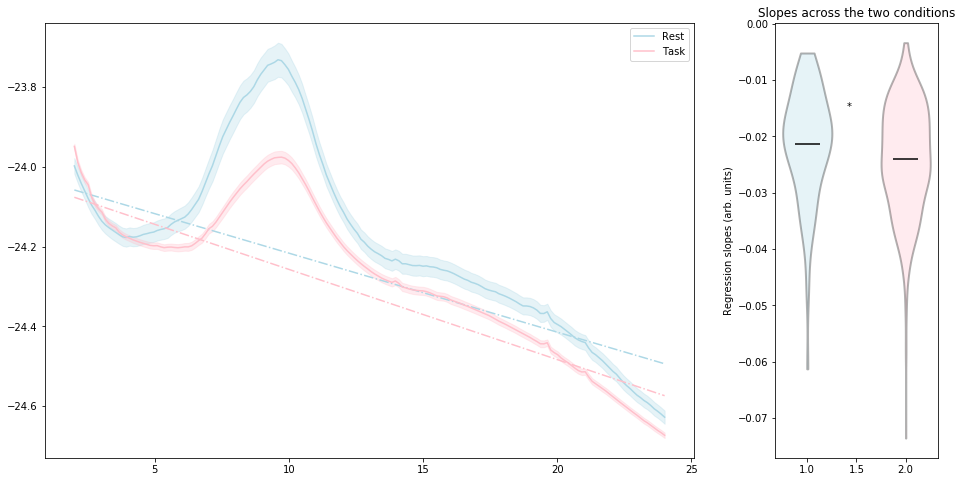

In [19]:
x = freqs
plt.figure(figsize=(16, 8))

# actually plot the spectra
plt.subplot2grid((1, 4), (0, 0), colspan=3)
lines = []
colors = [[1, 0.4, 0.4], [0.4, 0.4, 1]]
labels = ['Task', 'Rest']
for name, data in psds.items():
    
    pltdata = np.log10(
        np.stack([p[~e, :].mean(axis=0) for p, e in zip(data, bad_elecs[name])],
                 axis=-1)
    )
    
    line = plt.plot(x, np.mean(pltdata, axis=-1),
                    color=colorscheme[name], label=name.capitalize())
    lines.append(line)
    
    # regression line
    linfit = scipy.stats.linregress(freqs[findices], np.mean(pltdata, axis=-1)[findices])
    x2 = np.array([freqs.min(), freqs.max()])
    y2 = linfit.slope*x2 + linfit.intercept
    plt.plot(x2, y2, '-.', color=colorscheme[name])
    
    plt.fill_between(
            x, np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
            np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1),
            color=colorscheme[name], alpha=0.3
        )
    plt.legend()

# plot the slopes between settings
ax = plt.subplot2grid((1, 4), (0, 3))
plt.title('Slopes across the two conditions')
plt.ylabel('Regression slopes (arb. units)')

# collect all the average slopes
slopevecs = [[p.slopes[~e].mean() for p, e in zip(data, bad_elecs[name])]
             for name, data in summary_data.items()]
# plot the boxes
boxplt = plt.violinplot(slopevecs, showextrema=False, showmeans=True)
# color the boxes appropriately
boxplt['cmeans'].set_color('black')
for b, n in zip(boxplt['bodies'], psds.keys()):
    b.set_facecolor(colorscheme[n])
    b.set_edgecolor('black')
    b.set_linewidth(2)

if scipy.stats.ttest_ind(*slopevecs).pvalue < 0.001:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='***')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.01:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='**')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.05:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='*')
else:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='n.d.')

plt.subplots_adjust(wspace=0.5)
plt.show()

### Check if the two correlate

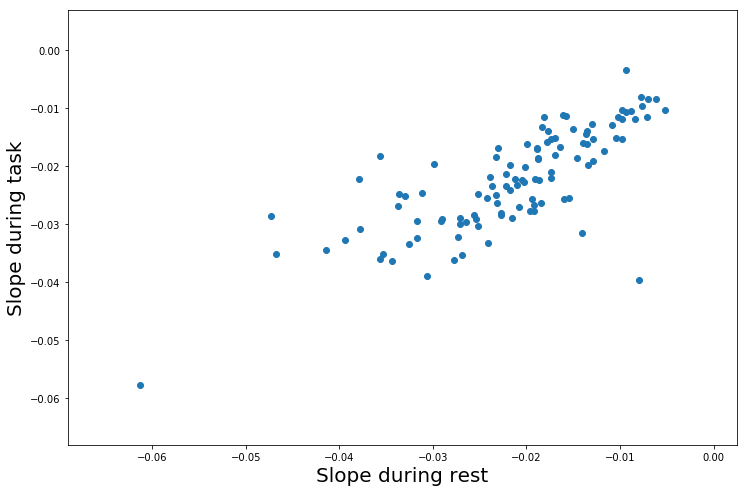

(0.76750631938000102, 3.3911068378711083e-22)


In [20]:
ids = {name: [p.pid for p in data]
       for name, data in summary_data.items()}

coords = [[np.mean(p.slopes[~e]) for p, e in zip(data, bad_elecs[name])
          if p.pid in ids['rest'] and p.pid in ids['task']]
          for name, data in summary_data.items()]
# x = [np.mean(p.slopes[~e]) for p, e in zip(summary_data['rest'], bad_elecs) if p.pid in restids]
# y = [np.mean(p.slopes[~e]) for p, e in zip(restall_parameters, restbad_elecs) if p.pid in taskids]

plt.figure(figsize=(12, 8))
plt.scatter(coords[0], coords[1])
plt.xlabel(f'Slope during {list(summary_data.keys())[0]}', fontsize=20)
plt.ylabel(f'Slope during {list(summary_data.keys())[1]}', fontsize=20)
plt.show()

print(scipy.stats.pearsonr(*coords))

### Make a split power spectrum for age groups in `task`

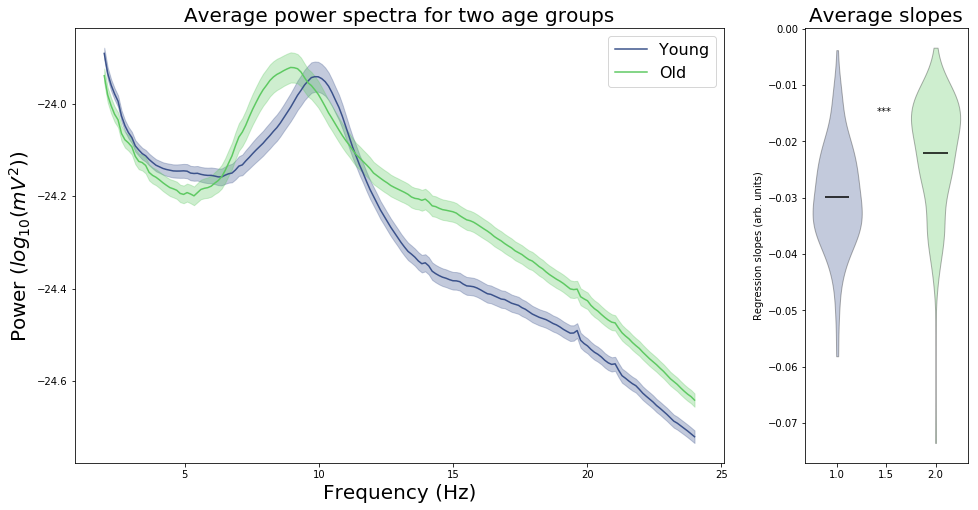

In [23]:
recording= 'task'

ages = np.array([p.age for p in summary_data[recording]])
agesplit = {'young': ages < np.percentile(ages, 25),
            'old': ages > np.percentile(ages, 75)}

young = ages < np.percentile(ages, 25)
old = ages > np.percentile(ages, 75)

plt.figure(figsize=(16, 8))

plt.subplot2grid((1, 4), (0, 0), colspan=3)
legendentries = []
for groupname, group in agesplit.items():
    pltdata = np.log10(np.stack([p[~e, :].mean(axis=0)
                                 for p, e, g in zip(psds[recording], bad_elecs[recording], group)
                                 if g],
                                axis=-1))
    plt.fill_between(
        freqs,
        np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
        np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1),
        color=colorscheme[groupname], alpha=0.3
    )
    legendentries.append(plt.plot(freqs, np.mean(pltdata, axis=-1),
                                  color=colorscheme[groupname],
                                  label=groupname.capitalize()))

plt.ylabel('Power ($log_{10}(mV^2)$)', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.title('Average power spectra for two age groups', fontsize=20)
plt.legend(fontsize=16)

# plot the slopes between settings
ax = plt.subplot2grid((1, 4), (0, 3))
plt.title('Average slopes', fontsize=20)
plt.ylabel('Regression slopes (arb. units)')

# collect all the average slopes
slopevecs = [[p.slopes[~e].mean()
              for i, (p, e) in enumerate(zip(summary_data[recording], bad_elecs[recording]))
              if g[i]]
             for groupname, g in agesplit.items()]
# plot the boxes
violins = plt.violinplot(slopevecs, showextrema=False, showmeans=True)
# color the boxes appropriately
for patch, groupname in zip(violins['bodies'], agesplit.keys()):
    patch.set_facecolor(colorscheme[groupname])
    patch.set_edgecolor('black')
    patch.set_alpha(0.3)
# make the mean line black
violins['cmeans'].set_color('black')

if scipy.stats.ttest_ind(*slopevecs).pvalue < 0.001:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='***')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.01:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='**')
elif scipy.stats.ttest_ind(*slopevecs).pvalue < 0.05:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='*')
else:
    plt.text(x=1.4, y=np.max(ax.get_ylim()) - 0.2*np.diff(ax.get_ylim()), s='n.d.')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [24]:
# write the split data to a csv file
outdicts = [
    {
        **{'pid': p.pid, 'group': 'young' if p.age < np.percentile(ages, 25) else 'old'},
        **{str(freq): power for freq, power in zip(freqs, np.log10(psd[~e, :]).mean(axis=0))}
    }
    for p, e, psd in zip(summary_data[recording], bad_elecs[recording], psds[recording])
    if (p.age < np.percentile(ages, 25)) or (p.age > np.percentile(ages, 75))
]

with open(csvroot / 'agesplit-spectra.csv', 'w+') as f:
    pd.DataFrame.from_dict(outdicts).to_csv(f, index=False)

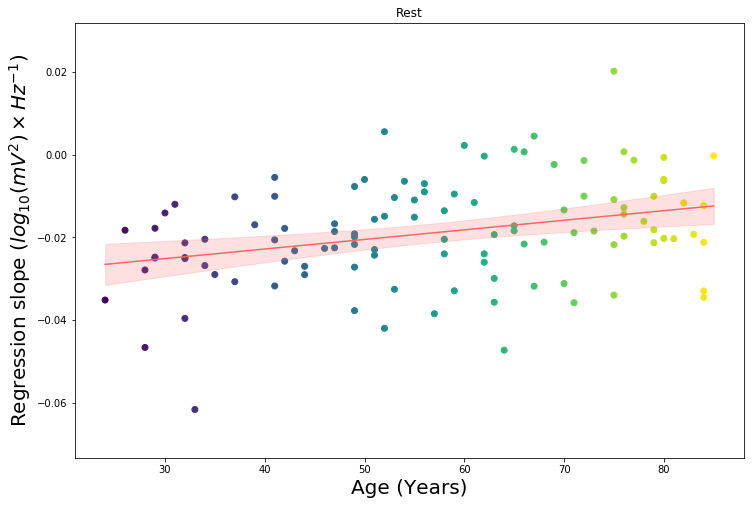

(0.31543909833306755, 0.00083465520378250867)


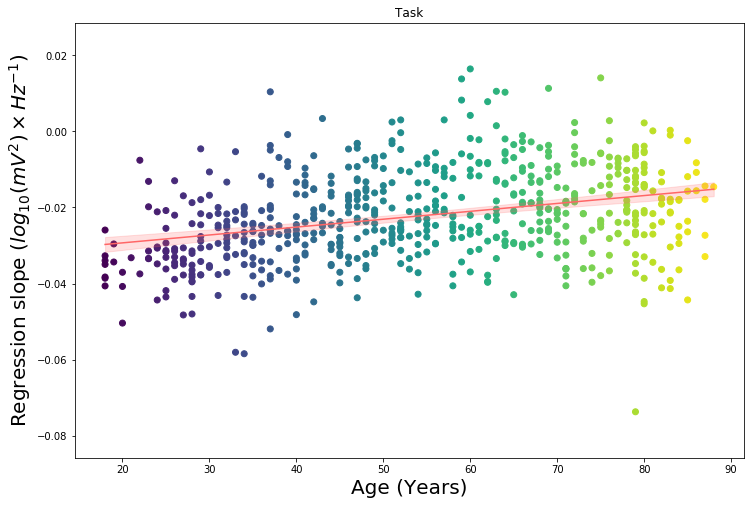

(0.32034726701665406, 9.7072295445765612e-17)


In [25]:
for recording, data in summary_data.items():
    x = np.array([p.age for p in data])
    y = np.array([np.mean(p.slopes) for p in data])
    plt.figure(figsize=(12, 8))
    plt.scatter(x, y, c=x)
    plot_linfit(x, y)
    plt.xlabel(r'Age (Years)', fontsize=20)
    plt.ylabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
    plt.title(recording.capitalize())
    plt.show()
    print(scipy.stats.pearsonr(x, y))


In [26]:
# Load the short-term memory data
stm = pd.read_csv(
    camcanroot / 'cc700-scored' / 'VSTMcolour' / 'release001' / 'summary' / 'VSTMcolour_summary.txt',
    sep='\t', skiprows=8, index_col=0
)

with open(csvroot / 'vstm-behavior.csv', 'w+') as f:
    stm.to_csv(f)

(-0.066509719757944133, 0.10077311325520133)


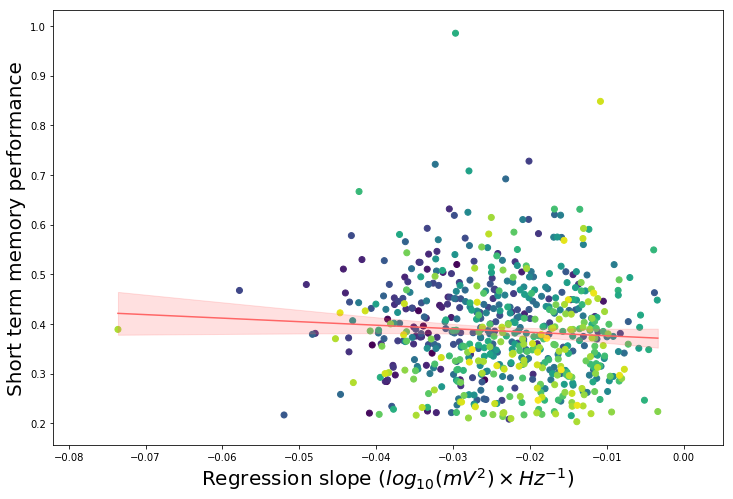

In [27]:
recording = 'task'

ages = np.array([p.age for p in summary_data[recording] if p.pid in stm.index])
slopes = [np.mean(p.slopes[~e])
          for p, e in zip(summary_data[recording], bad_elecs[recording])
          if p.pid in stm.index]

x = np.array(slopes)
y = np.array(
    [float(stm.loc[p.pid, 'Prcsn_ss3']) for p in summary_data[recording] if p.pid in stm.index]
)
# exclusion params
include = y < 1

x = x[include]
y = y[include]
c = ages[include]

print(scipy.stats.pearsonr(x, y))

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=c)
plot_linfit(x, y)
plt.ylabel(r'Short term memory performance', fontsize=20)
plt.xlabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()

(-0.0075748607959751834, 0.84974013832389983)


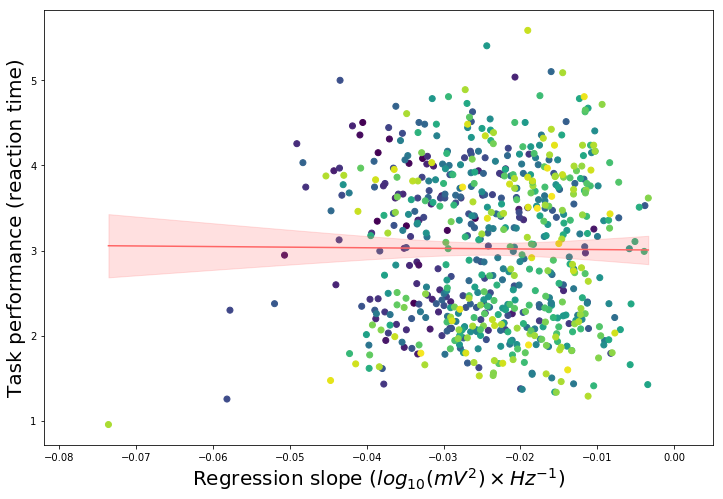

In [28]:
recording = 'task'

megbehaviorroot = camcanroot / 'cc700-scored' / 'MEG' / 'release001' / 'data'
megmeanrt = []
megmedianrt = []

ages = []

rtdicts = []

for p in summary_data[recording]:
    try:
        meg_behaviour = pd.read_csv(
            megbehaviorroot / p.pid / ('MEG_' + p.pid + '_scored.txt'), sep='\t'
        )
        megmeanrt.append(meg_behaviour.loc[0, 'mRT_inv_trim'])
        megmedianrt.append(meg_behaviour.loc[0, 'mdnRT_inv_trim'])
        ages.append(p.age)
        rtdicts.append({'pid': p.pid, 'age': p.age,
                        'mean.rt': megmeanrt,
                        'median.rt': megmedianrt})
    except:
        ages.append(np.nan)
        megmeanrt.append(np.nan)
        megmedianrt.append(np.nan)



slopes = np.array([np.mean(p.slopes[~e]) for p, e in zip(summary_data[recording], bad_elecs[recording])])

x = slopes
y = np.array(megmedianrt)
include = (~np.isnan(x) & ~np.isnan(y))
x = x[include]
y = y[include]
c = np.array(ages)[include]

print(scipy.stats.pearsonr(x, y))

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c=c)
plot_linfit(x, y)
plt.ylabel(r'Task performance (reaction time)', fontsize=20)
plt.xlabel(r'Regression slope ($log_{10}(mV^2) \times Hz^{-1}$)', fontsize=20)
plt.show()

In [29]:
with open(csvroot / 'megbehavior.csv', 'w+') as f:
    pd.DataFrame.from_dict(rtdicts).to_csv(f, index=False)

### Check if correlations are locally more strong


In [54]:
recording = 'task'

for channel in range(len(summary_data['task'][0].slopes)):
    slopes = np.array([np.nan if e[channel] else np.mean(p.slopes[channel])
                       for p, e in zip(summary_data[recording], bad_elecs[recording])])
    y = np.array(megmeanrt)
    include = ~np.isnan(slopes) & ~np.isnan(y)
    slopes, y = slopes[include], y[include]
    print(scipy.stats.pearsonr(slopes, y))

(-0.0038917536296197634, 0.9237705183552164)
(0.024962925573593871, 0.54782570364670802)
(-0.0021249498127495379, 0.95881810804652667)
(0.013104521838077596, 0.7489151783463861)
(-0.0030682267888949618, 0.94101964473691235)
(0.0079654467153076891, 0.84409789503923838)
(-0.0072747710652389455, 0.85827690880934904)
(0.061947167371868561, 0.1428170461611018)
(-0.021309701774047448, 0.61260447387942996)
(-0.0078654324986269179, 0.84943805702959352)
(-0.036151664785003396, 0.42602751712772657)
(-0.024949575392934211, 0.5611010414155897)
(-0.028644394599423879, 0.52616086261691319)
(-0.014817600334365339, 0.72666128457522883)
(0.015448437166837676, 0.70710988257047758)
(-0.015299717353704591, 0.71717249200948585)
(0.01768737912853487, 0.66704691483052292)
(0.00054995242690159863, 0.98922962988156682)
(-0.037149208383404027, 0.39382293011277902)
(0.0059958380107043236, 0.88661889260551363)
(-0.039201361581556265, 0.36414097689588154)
(-0.015513852489320929, 0.71683310876800121)
(-0.0246040131

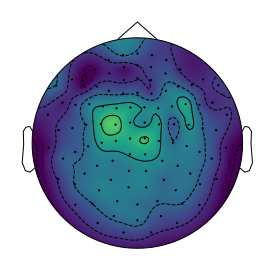

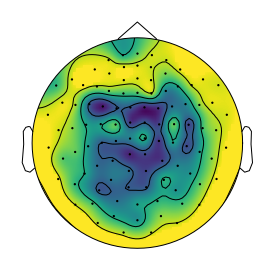

In [78]:
rvals = []
pvals = []

for channel in range(0, len(summary_data['task'][0].slopes), 2):
    slopes = [np.nan if e[channel] else np.mean((p.slopes[channel], p.slopes[channel+1]))
              for p, e in zip(summary_data[recording], bad_elecs[recording])
              if p.pid in stm.index]

    slopes = np.array(slopes)
    y = np.array(
        [float(stm.loc[p.pid, 'Prcsn_ss3']) for p in summary_data[recording] if p.pid in stm.index]
    )
    
    include = ~np.isnan(slopes) & ~np.isnan(y)
    slopes, y = slopes[include], y[include]
    rval, pval = scipy.stats.pearsonr(slopes, y)
    rvals.append(rval)
    pvals.append(1-pval)

mne.viz.plot_topomap(data=rvals, pos=pos, cmap='viridis')
mne.viz.plot_topomap(data=pvals, pos=pos, vmin=0, vmax=1, cmap='viridis');

In [75]:
list(range(1, 10, 2))

[1, 3, 5, 7, 9]